In [1]:
!pip install transformers datasets torch torchvision pytesseract
!apt-get update && apt-get install -y tesseract-ocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import json
import torch
import pytesseract
import random
from PIL import Image
from transformers import LayoutLMv3Processor
from datasets import Dataset

In [3]:


# Dossiers des images et annotations
dataset_path = "dataset/wpayslip/jpeg/"
json_path = "dataset/wpayslip/json/"

# Initialiser le processeur LayoutLMv3
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

# Fonction OCR pour extraire texte et coordonnées
def extract_text_and_bboxes(image):
    ocr_data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

    words = []
    bboxes = []

    for i in range(len(ocr_data["text"])):
        word = ocr_data["text"][i].strip()
        if word:  # Ne garder que les mots non vides
            x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]
            words.append(word)
            bboxes.append([x, y, x + w, y + h])  # Format [x_min, y_min, x_max, y_max]

    return words, bboxes

# Fonction pour traiter une image et son annotation
# Mapping des labels en nombres
label_mapping = {
    "charge": 0,
    "fiche_salaire": 1
}

def process_sample(image_filename):
    image_filepath = os.path.join(dataset_path, image_filename)
    json_filepath = os.path.join(json_path, image_filename.replace(".jpeg", ".json"))  # Supposons que JSON a le même nom que l'image

    # Vérifier si le fichier JSON existe
    if not os.path.exists(json_filepath):
        print(f"⚠️ Pas d'annotation trouvée pour {image_filename}")
        return None

    # Charger l'image
    image = Image.open(image_filepath).convert("RGB")

    # Charger les annotations
    with open(json_filepath, "r", encoding="utf-8") as f:
        annotations = json.load(f)

    words = annotations.get("words", [])
    bboxes = annotations.get("bboxes", [])

    # Vérifier si OCR vide
    if not words or not bboxes:
        print(f"⚠️ Aucun texte détecté dans {image_filename}")
        return None

    # Récupérer le label et le convertir en entier
    label_str = annotations.get("label", "unknown")  # Récupération du label texte
    label = label_mapping.get(label_str, -1)  # Conversion en nombre
    if label == -1:
        print(f"⚠️ Label inconnu pour {image_filename}: {label_str}")
        return None

    # Encoder avec LayoutLMv3
    encoding = processor(images=image, text=words, boxes=bboxes, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

    # Vérifier que l'encodage a fonctionné
    if "input_ids" not in encoding or "bbox" not in encoding:
        print(f"⚠️ Problème d'encodage pour {image_filename}")
        return None

    # Convertir en format compatible Dataset
    encoding = {key: val.squeeze(0).tolist() for key, val in encoding.items()}
    encoding["labels"] = label  # Stocker le label sous forme d'entier

    return encoding

# Liste pour stocker les données
dataset_list = []

# Charger les données
for file in os.listdir(dataset_path):
    if file.endswith(".jpeg"):
        encoding = process_sample(file)
        if encoding:  # Vérifier que l'encodage n'est pas `None`
            dataset_list.append(encoding)

# Transformer en Dataset Hugging Face
if dataset_list:
    dataset = Dataset.from_list(dataset_list)
    print(dataset)
else:
    print("Aucune donnée chargée dans le Dataset.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'bbox', 'pixel_values', 'labels'],
    num_rows: 205
})


In [4]:
print(dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'bbox', 'pixel_values', 'labels'],
    num_rows: 205
})


In [18]:
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]


In [19]:
print(train_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'bbox', 'pixel_values', 'labels'],
    num_rows: 164
})


In [7]:
from transformers import LayoutLMv3Processor, LayoutLMv3ForSequenceClassification, TrainingArguments, Trainer


#5️⃣ Entraîner LayoutLMv3

## Avec pré entrainement CNN + Dense

In [ ]:
# Charger le Modèle keras
from keras.models import load_model


old_model = load_model("mon_modele.keras")
old_model.summary()  # Vérifie la structure

# Récupérer la dernière couche Dense avant softmax
dense_weights = old_model.layers[-2].get_weights()

In [ ]:
print (dense_weights)

In [ ]:
# Charger la modèle avec avec les poids du CNN
import torch.nn as nn

num_classes = old_model.layers[-1].output_shape[-1]  # Nombre de classes

# Charger LayoutLMv3
model = LayoutLMv3ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_classes
)

# Remplacer la couche de classification par celle du CNN
model.classifier = nn.Linear(in_features=768, out_features=75)  # Adapter si nécessaire
model.classifier.weight.data = torch.tensor(dense_weights[0].T)  # Transposer car PyTorch et Keras inversent les dimensions
model.classifier.bias.data = torch.tensor(dense_weights[1])

## Normal

In [8]:
# Charger le modèle normal
num_classes = len(label_mapping)

model = LayoutLMv3ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=num_classes
)

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# Définir l'Entraînement
training_args = TrainingArguments(
    output_dir="./layoutlmv3_model",
    run_name="pipeline 2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=6,
    report_to="none",  # 🔥 Désactive `wandb`
    logging_strategy="epoch"
)


# Définir Trainer et Lancer l'Entraînement
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # Ajout du dataset de validation
    tokenizer=processor,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-4622fc85989b>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.245700,0.174384
2,0.203000,0.152391
3,0.181300,0.149949


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=246, training_loss=0.21001160629396518, metrics={'train_runtime': 97.0786, 'train_samples_per_second': 5.068, 'train_steps_per_second': 2.534, 'total_flos': 130580652367872.0, 'train_loss': 0.21001160629396518, 'epoch': 3.0})

# 6️⃣ Évaluer et Tester le Modèle

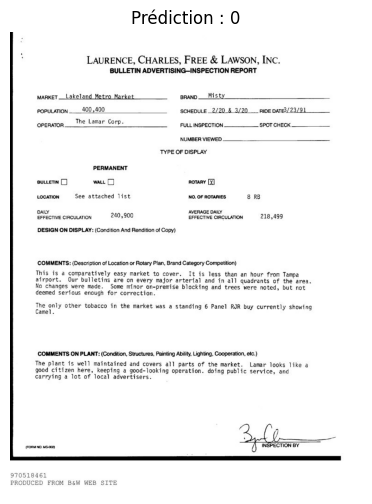

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


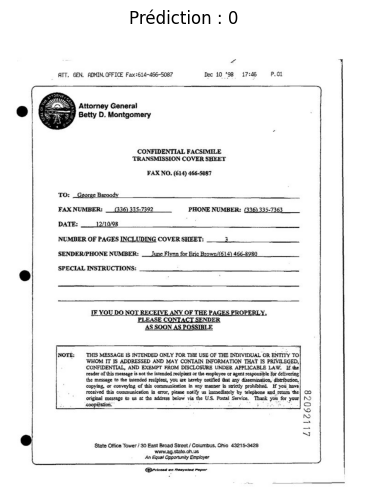

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


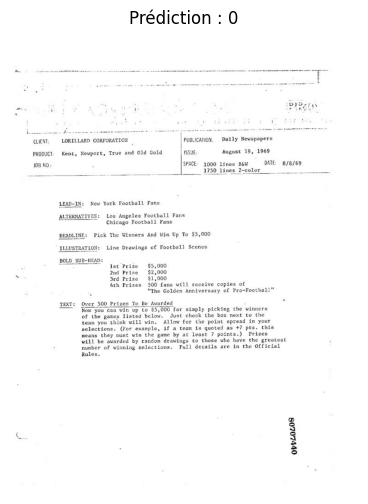

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


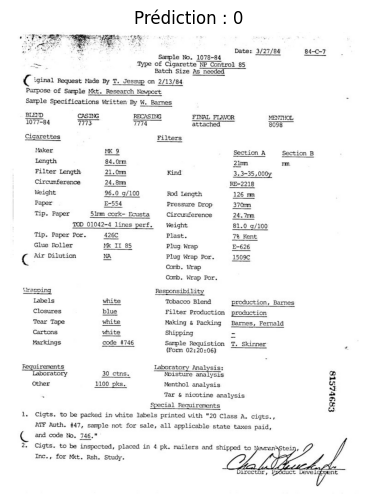

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


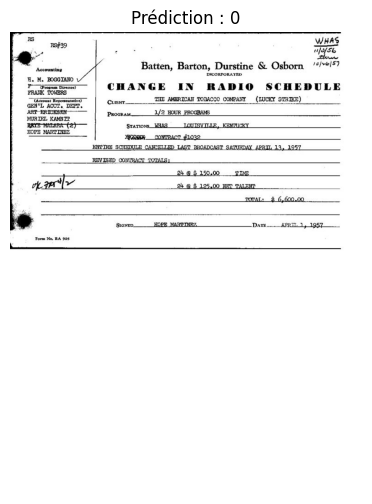

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


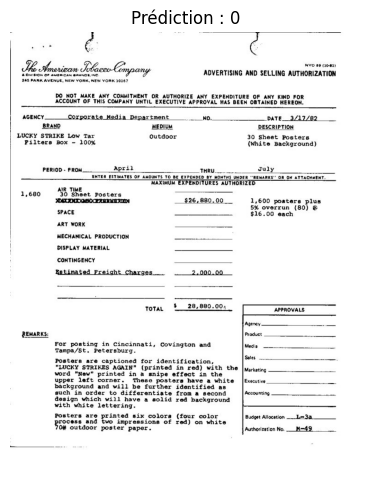

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


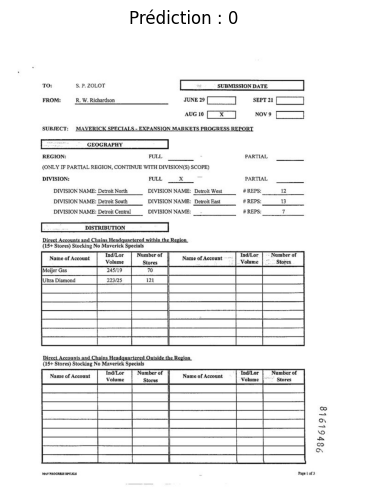

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


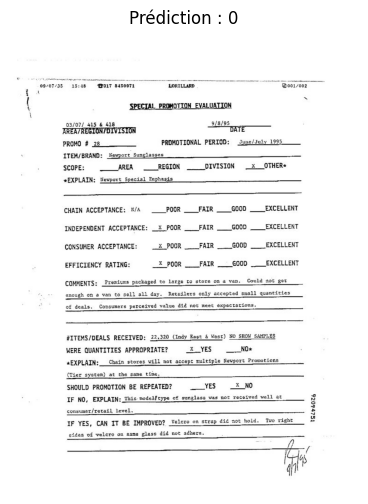

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


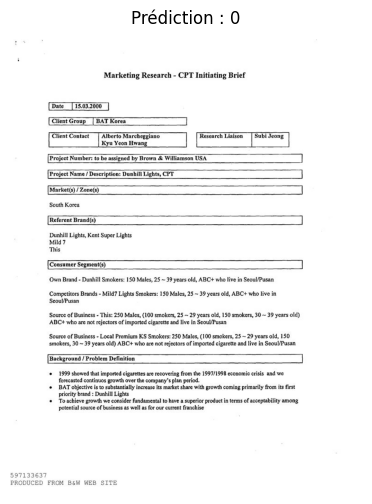

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


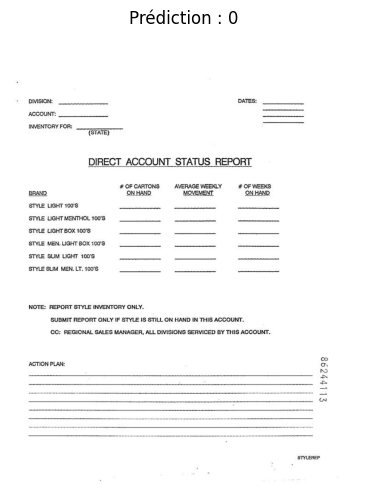

Écriture comptable associée :
Débit | Crédit | Libellé | Montant
charge | crédit | Charges à payer | Montant inconnu
--------------------------------------------------


In [24]:
import matplotlib.pyplot as plt

# Mettre le modèle en mode évaluation
model.eval()

def get_image_from_filename(image_filename):
    """Charge l'image depuis son nom de fichier"""
    image_filepath = os.path.join(dataset_path, image_filename)
    return Image.open(image_filepath).convert("RGB")

def predict_with_images(model, dataset, processor, num_samples=10):
    """Effectue la prédiction et affiche l'image avec l'écriture comptable"""
    for i in range(num_samples):
        sample = dataset[i]
        input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0)  # Ajouter batch dimension
        bbox = torch.tensor(sample["bbox"]).unsqueeze(0)
        attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0)

        # Prédiction
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids.to(model.device),
                bbox=bbox.to(model.device),
                attention_mask=attention_mask.to(model.device)
        )
        predicted_label = torch.argmax(outputs.logits, dim=1).item()

        # Récupérer l'image associée
        image_filename = os.listdir(dataset_path)[i]  # Récupère le i-ème fichier
        image = get_image_from_filename(image_filename)

        # Générer l'écriture comptable en fonction du label prédit
        if predicted_label == 1:  # 1 correspond à "fiche_salaire"
            ecriture = [
                ("Salary", "caisse", "Salaire Payment", "Montant inconnu")
            ]
        elif predicted_label == 0:  # 0 correspond à "charge"
            ecriture = [
                ("charge", "crédit", "Charges à payer", "Montant inconnu")
            ]
        else:
            ecriture = [("N/A", "N/A", "Label inconnu", "N/A")]

        # Affichage du document et de l'écriture comptable
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Prédiction : {predicted_label}")
        plt.axis("off")
        plt.show()

        print("Écriture comptable associée :")
        print("Débit | Crédit | Libellé | Montant")
        for ligne in ecriture:
            print(" | ".join(map(str, ligne)))
        print("-" * 50)

# Exécuter la prédiction
predict_with_images(model, test_dataset, processor, num_samples=10)
